# UNZIP file

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from zipfile import ZipFile

with ZipFile("/content/drive/MyDrive/Paper work/SalmonScan.zip",'r') as zipobj:
  zipobj.extractall("/content/SalmonScan")





# Spliting the dataset



```
pip install split-folders
```

YT LINk for help :[link ](https://youtu.be/C6wbr1jJvVs?si=R9SslwqTRy1VAG_R)

Github LINk for help :[link ](https://github.com/bnsreenu/python_for_microscopists/blob/master/221_split_folder_into_train_test_val.py)

In [3]:
pip install split-folders

In [4]:
import splitfolders  # or import split_folders

In [ ]:

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
#Train, val, test
input_folder = '/content/Dog and Cat/Dog and Cat .png'

splitfolders.ratio(input_folder, output="Dog and Cat Split",
                   seed=42, ratio=(.8, .2),
                   group_prefix=None) # default values


Copying files: 528 files [00:00, 3700.62 files/s]


### Making a function for reuse in future

In [7]:
def split_folders(input_folder ,output_folder,train=0.8,test=0.2 ,seed=42):
  """
  input:
  input_folder ,output_folder

  defult:
  train=0.7,test=0.2 ,val=0.1,seed=42

   Split with a ratio.
   To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
   Train, val, test

  Need install : pip install split-folders
  """

  import splitfolders  # or import split_folders
  splitfolders.ratio(input_folder, output=output_folder,
                   seed=seed, ratio=(train, test ),
                   group_prefix=None) # default values

split_folders("/content/SalmonScan",'SalmonScan split part_2',train=.8,test=.2)

Copying files: 1208 files [00:00, 2801.96 files/s]


# Image Load

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

In [24]:

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class) # Changed
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img


Image shape: (250, 600, 3)


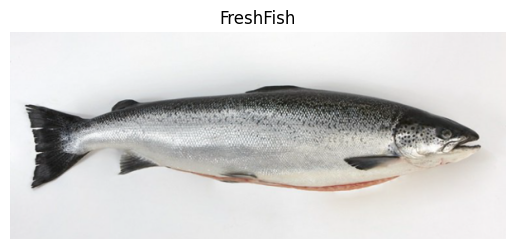

In [32]:
img = view_random_image(target_dir="/content/SalmonScan split part_2/train/",
                        target_class="FreshFish")

Image shape: (250, 600, 3)


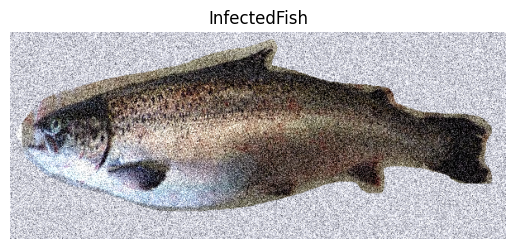

In [34]:
img = view_random_image(target_dir="/content/SalmonScan split part_2/train/",
                        target_class="InfectedFish")

# Making a function to see random image from directory and target class

In [39]:
def random_view(T_target_dir , T_target_class  , Te_target_dir , Te_target_class ):
  plt.figure(figsize=(16,10))
  for i in range(10):
    ax=plt.subplot( 5 ,2 ,i+1 )
    if(i%2==1):
      view_random_image(T_target_dir, T_target_class)
    else:
      view_random_image(Te_target_dir, Te_target_class)

Image shape: (250, 600, 3)
Image shape: (250, 600, 3)
Image shape: (250, 600, 3)
Image shape: (250, 600, 3)
Image shape: (250, 600, 3)
Image shape: (250, 600, 3)
Image shape: (250, 600, 3)
Image shape: (250, 600, 3)
Image shape: (250, 600, 3)
Image shape: (250, 600, 3)


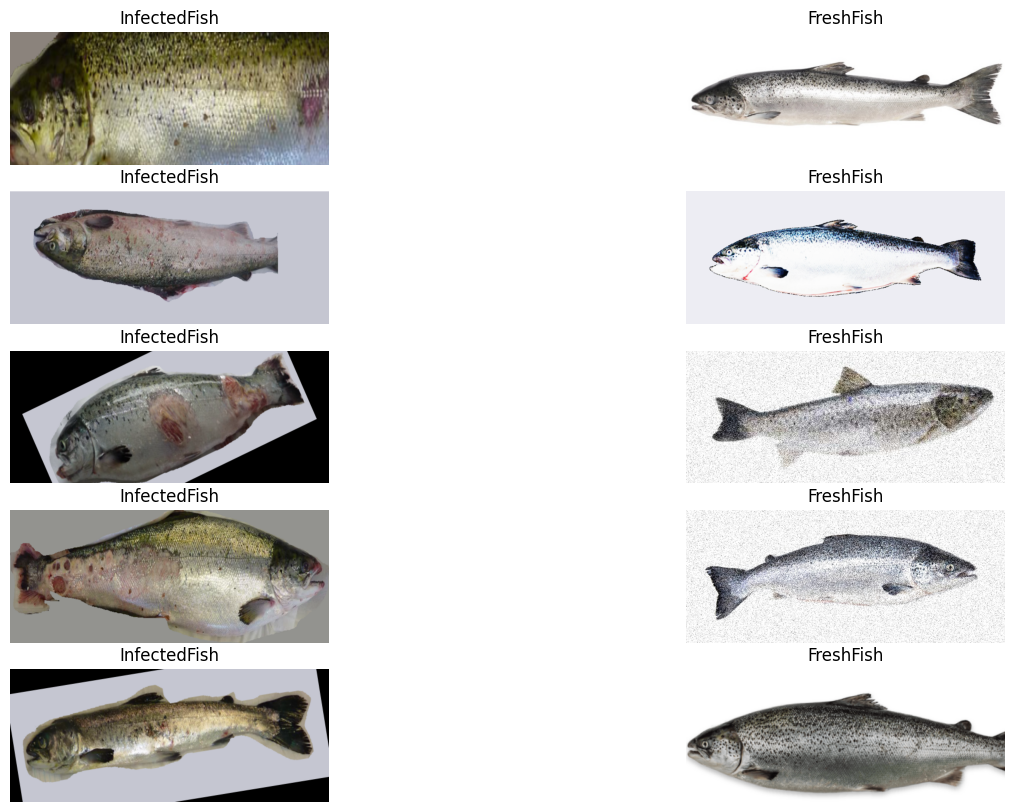

In [40]:
 random_view("/content/SalmonScan split part_2/train/","FreshFish","/content/SalmonScan split part_2/train/", "InfectedFish" )

# Creating data loaders (preparing the data)


In [8]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf


IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "/content/SalmonScan split part_1/train"
test_dir = "/content/SalmonScan split part_1/val"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")

train_data_10_percent = train_datagen.flow_from_directory(train_dir,
target_size=IMAGE_SHAPE,
batch_size=BATCH_SIZE,
class_mode="binary")

print("Testing images:")

test_data = train_datagen.flow_from_directory(test_dir,
target_size=IMAGE_SHAPE,
batch_size=BATCH_SIZE,
class_mode="binary")

Training images:
Found 965 images belonging to 2 classes.
Testing images:
Found 243 images belonging to 2 classes.


# Setting up callbacks (things to run whilst our model trains)


In [9]:
# Create tensorboard callback (functionized because need to create a new one for each mode
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

  tensorboard_callback = tf.keras.callbacks.TensorBoard(
  log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Creating models using TensorFlow Hub

In [10]:

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

### Resnet 50 V2 feature vector

In [11]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

## Model function for tensorflow hub

In [12]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='sigmoid', name='output_layer') # create our own output layer
  ])

  return model

In [18]:

# Create model
resnet_model = create_model(resnet_url, num_classes=1)

In [19]:
resnet_model.compile(loss='binary_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [20]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files


Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20231004-071848
Epoch 1/5
31/31 [==============================] - 23s 267ms/step - loss: 0.4914 - accuracy: 0.7596 - val_loss: 0.3585 - val_accuracy: 0.8765
Epoch 2/5
31/31 [==============================] - 7s 238ms/step - loss: 0.2562 - accuracy: 0.9119 - val_loss: 0.2782 - val_accuracy: 0.9053
Epoch 3/5
31/31 [==============================] - 6s 191ms/step - loss: 0.2104 - accuracy: 0.9306 - val_loss: 0.2489 - val_accuracy: 0.9136
Epoch 4/5
31/31 [==============================] - 6s 206ms/step - loss: 0.1820 - accuracy: 0.9399 - val_loss: 0.2473 - val_accuracy: 0.9177
Epoch 5/5
31/31 [==============================] - 6s 177ms/step - loss: 0.1671 - accuracy: 0.9399 - val_loss: 0.2336 - val_accuracy: 0.9218


# Making a comparing history function

In [49]:
import matplotlib.pyplot as plt

def plot_compare_history(histories):
    """
    Plots separate loss curves for training and validation metrics for multiple histories.
    """
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Define colors for each history

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))

    for i, history in enumerate(histories):
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        accuracy = history.history['accuracy']
        val_accuracy = history.history['val_accuracy']

        epochs = range(len(history.history['loss']))

        # Plot loss
        ax1.plot(epochs, loss, label=f'Training Loss {i+1}', color=colors[i])
        ax1.plot(epochs, val_loss, label=f'Validation Loss {i+1}', linestyle='--', color=colors[i])
        ax1.set_title('Loss')
        ax1.set_xlabel('Epochs')
        ax1.legend()

        # Plot accuracy
        ax2.plot(epochs, accuracy, label=f'Training Accuracy {i+1}', color=colors[i])
        ax2.plot(epochs, val_accuracy, label=f'Validation Accuracy {i+1}', linestyle='--', color=colors[i])
        ax2.set_title('Accuracy')
        ax2.set_xlabel('Epochs')
        ax2.legend()

    # Display the plot
    plt.tight_layout()
    plt.show()


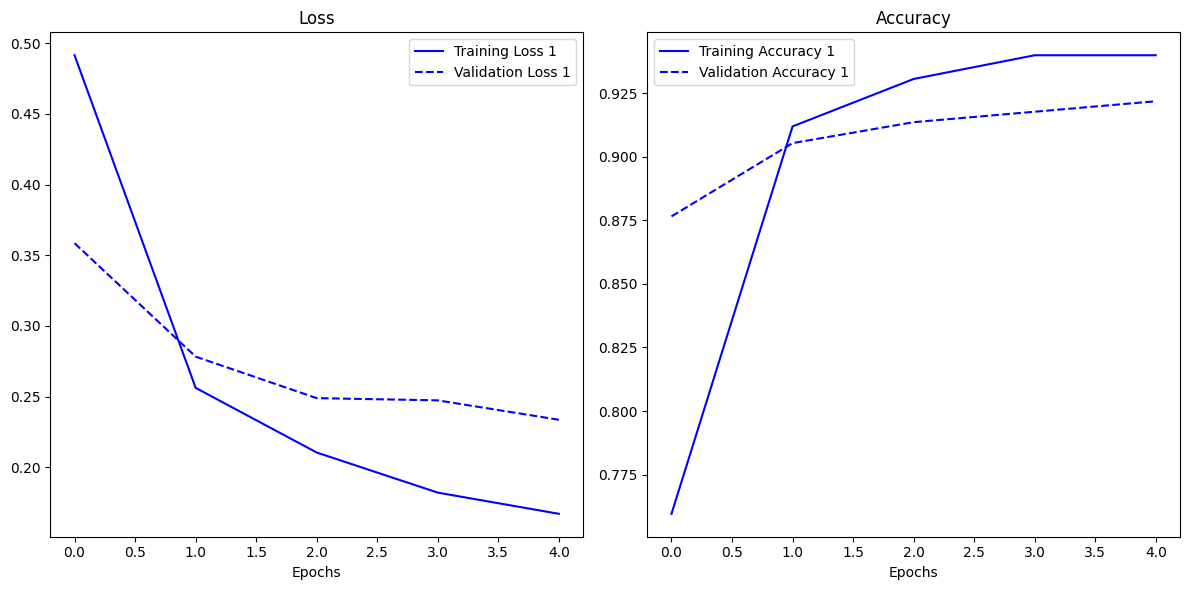

In [22]:
histories = [ resnet_history]
plot_compare_history(histories)

# Improving Model with Data augmentation

In [41]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True) # flip the image on the horizontal axis

# Create ImageDataGenerator training instance without data augmentation
train_datagen = ImageDataGenerator(rescale=1/255.)

# Create ImageDataGenerator test instance without data augmentation
test_datagen = ImageDataGenerator(rescale=1/255.)

### Here Shuffle is false

In [42]:
# Import data and augment it from training directory
print("Augmented training images:")
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode='binary',
                                                                   shuffle=False) # Don't shuffle for demonstration purposes, usually a good thing to shuffle

# Create non-augmented data batches
print("Non-augmented training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='binary',
                                               shuffle=False) # Don't shuffle for demonstration purposes

print("Unchanged test images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='binary')

Augmented training images:
Found 965 images belonging to 2 classes.
Non-augmented training images:
Found 965 images belonging to 2 classes.
Unchanged test images:
Found 243 images belonging to 2 classes.


### Get data batch samples

In [43]:

images, labels = train_data.next()
augmented_images, augmented_labels = train_data_augmented.next()

### Show original image and augmented image

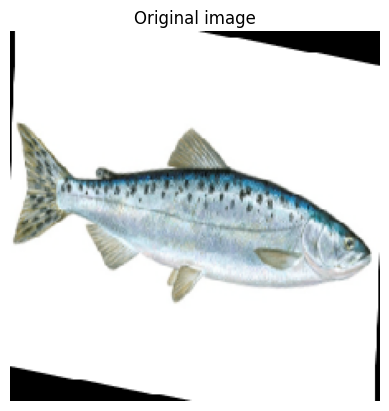

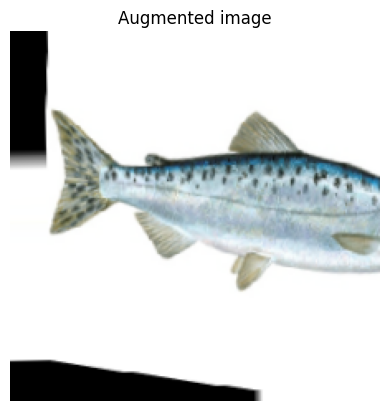

In [79]:

# Show original image and augmented image
random_number = random.randint(0, 32) # we're making batches of size 32, so we'll get a random instance

plt.imshow(images[random_number])
plt.title(f"Original image")
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image")
plt.axis(False);

### Fit the model in resnet_model

In [54]:
# Fit the model
resnet_history_Augmented = resnet_model.fit(train_data_augmented,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_augmented),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2_Augmented")]) # name of log files


Saving TensorBoard log files to: tensorflow_hub/resnet50V2_Augmented/20231004-073828
Epoch 1/5
31/31 [==============================] - 17s 531ms/step - loss: 0.2533 - accuracy: 0.9036 - val_loss: 0.2801 - val_accuracy: 0.9095
Epoch 2/5
31/31 [==============================] - 16s 524ms/step - loss: 0.2091 - accuracy: 0.9161 - val_loss: 0.2404 - val_accuracy: 0.9136
Epoch 3/5
31/31 [==============================] - 18s 571ms/step - loss: 0.2119 - accuracy: 0.9181 - val_loss: 0.2346 - val_accuracy: 0.9177
Epoch 4/5
31/31 [==============================] - 18s 567ms/step - loss: 0.2238 - accuracy: 0.9088 - val_loss: 0.2437 - val_accuracy: 0.9177
Epoch 5/5
31/31 [==============================] - 16s 527ms/step - loss: 0.2146 - accuracy: 0.9057 - val_loss: 0.2305 - val_accuracy: 0.9136


# History Compare of  resnet_history and  resnet_history_Augmented

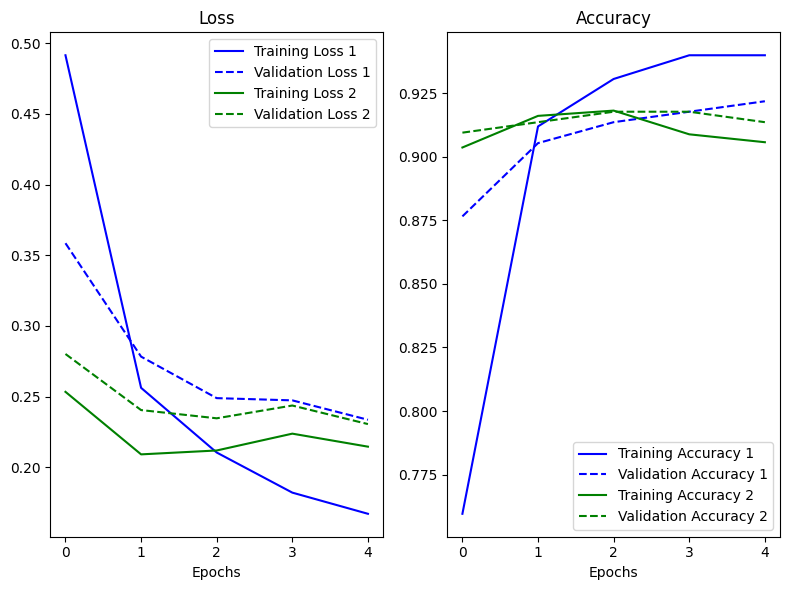

In [55]:
histories = [ resnet_history ,resnet_history_Augmented]
plot_compare_history(histories)

# Prediction

## Load and prepared image function

In [56]:
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img


## Model and file show function for prediction

In [57]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);


image copy path :/content/SalmonScan split part_1/val/InfectedFish/infected_326.png
1/1 [==============================] - 0s 21ms/step


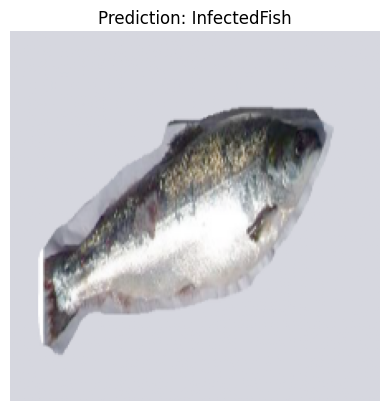

In [78]:
class_names=["FreshFish", "InfectedFish"]

image = input("image copy path :")

pred_and_plot(resnet_model, image, class_names)